In [17]:

"""
================================================================================
ENSEMBLE & HYBRID RECOMMENDATION SYSTEM
================================================================================

Этот ноутбук:
1. Загружает лучшие модели из advanced_ml_models.ipynb (786 признаков)
2. Создает ensemble моделей (Simple, Grid Search, Stacking)
3. Реализует hybrid системы (Rule-based, Adaptive)
4. Сравнивает все подходы

Используемые модели:
- CatBoost: RMSE 0.7731 (лучшая)
- LightGBM: RMSE 0.7869
- KNN: RMSE 0.7819
"""

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("="*80)
print("ENSEMBLE & HYBRID RECOMMENDATION SYSTEM")
print("="*80)


ENSEMBLE & HYBRID RECOMMENDATION SYSTEM


In [18]:
import os
# Автопоиск файлов в проекте
def find(f, r='..'):
    for p, d, files in os.walk(r):
        d[:] = [x for x in d if x not in ['.git', '__pycache__', '.ipynb_checkpoints']]
        if f in files: return os.path.join(p, f)
    raise FileNotFoundError(f"'{f}' не найден!")


In [19]:

# ============================================================================
# [0/9] ЗАГРУЗКА ДАННЫХ И МОДЕЛЕЙ
# ============================================================================

print("\n[0/9] ЗАГРУЗКА ДАННЫХ...")

# Данные
train_df = pd.read_csv(find('train_features_full.csv'))
test_df = pd.read_csv(find('test_features_full.csv'))

print(f" Train: {len(train_df):,}")
print(f" Test: {len(test_df):,}")

# Модели и предсказания из advanced_ml_models.ipynb (786 признаков)
with open(find('ml_models_full_features.pkl'), 'rb') as f:
    models_dict = pickle.load(f)

catboost_model = models_dict['catboost']
lgb_model = models_dict['lightgbm']
knn_model = models_dict['knn_features']
scaler = models_dict['scaler']
scaler_base = models_dict['scaler_base']

print(" Модели: CatBoost, LightGBM, KNN")

# Baseline artifacts
with open(find('baseline_artifacts.pkl'), 'rb') as f:
    baseline_artifacts = pickle.load(f)

global_mean = baseline_artifacts['global_mean']
user_bias_dict = baseline_artifacts['user_bias_dict']
book_bias_dict = baseline_artifacts['book_bias_dict']
baseline_rmse = baseline_artifacts['best_baseline_rmse']

print(f" Baseline RMSE: {baseline_rmse:.4f}")

# Предсказания на test
predictions_dict = np.load(find('ml_predictions_full.npy'), allow_pickle=True).item()

catboost_pred = predictions_dict['catboost']
lgb_pred = predictions_dict['lightgbm']
knn_pred = predictions_dict['knn_features']
y_test = predictions_dict['y_test']

print(f" Загружены предсказания: {len(catboost_pred):,} samples")

# Embeddings для content-based
with open(find('book_embeddings.pkl'), 'rb') as f:
    book_embeddings = pickle.load(f)

with open(find('user_embeddings.pkl'), 'rb') as f:
    user_embeddings = pickle.load(f)

print(" Embeddings загружены")



[0/9] ЗАГРУЗКА ДАННЫХ...
 Train: 874,496
 Test: 107,260
 Модели: CatBoost, LightGBM, KNN
 Baseline RMSE: 0.8104
 Загружены предсказания: 107,260 samples
 Embeddings загружены



[1/9] ПРОВЕРКА ОДИНОЧНЫХ МОДЕЛЕЙ
 CatBoost (786 features)
   RMSE: 0.7731 (+4.60%)
   MAE: 0.5919
   RMSE(low): 1.0658
   RMSE(high): 0.5669

 LightGBM (786 features)
   RMSE: 0.7869 (+2.90%)
   MAE: 0.6019
   RMSE(low): 1.0890
   RMSE(high): 0.5728

 KNN базовые фичи (k=50)
   RMSE: 0.7819 (+3.51%)
   MAE: 0.6157
   RMSE(low): 1.0747
   RMSE(high): 0.5764

[2/9] SIMPLE WEIGHTED ENSEMBLE

 Веса основаны на производительности:
   CatBoost (лучшая): 0.50
   LightGBM (2-я): 0.30
   KNN (3-я): 0.20
 Simple Weighted Ensemble
   RMSE: 0.7646 (+5.65%)
   MAE: 0.5888
   RMSE(low): 1.0627
   RMSE(high): 0.5521

[3/9] OPTIMIZED WEIGHTED ENSEMBLE (GRID SEARCH)

 Поиск оптимальных весов...
 Диапазон: w1, w2 в [0.15, 0.65] с шагом 0.05
 Ограничение: w3 = 1 - w1 - w2 >= 0.15
 Комбинаций для проверки: 63


 Grid Search: 100%|██████████| 63/63 [00:00<00:00, 732.60it/s]


 Оптимальные веса:
   CatBoost: 0.150
   LightGBM: 0.350
   KNN: 0.500
 Optimized Weighted Ensemble
   RMSE: 0.7585 (+6.40%)
   MAE: 0.5898
   RMSE(low): 1.0595
   RMSE(high): 0.5426

[4/9] STACKING META-MODEL

 Meta-learner: Ridge регрессия
 Split: 50% train / 50% validation
   Meta-train: 53,630
   Meta-val: 53,630



 Коэффициенты Ridge:
   CatBoost: -0.1518
   LightGBM: 0.7943
   KNN: 0.3053
   Intercept: -0.0273
 Stacking Ridge
   RMSE: 0.7256 (+10.47%)
   MAE: 0.5773
   RMSE(low): 0.8928
   RMSE(high): 0.6223

[5/9] HYBRID SYSTEM - RULE-BASED

 Сегментация по активности пользователя:
   NEW (<=5 ratings): 70% baseline + 30% ML
   INACTIVE (6-20): 50% baseline + 50% ML
   ACTIVE (21-50): 30% baseline + 70% ML
   VERY ACTIVE (>50): 10% baseline + 90% ML

 Расчет baseline predictions...


 Processing: 100%|██████████| 107260/107260 [00:02<00:00, 36302.43it/s]



 Применение rule-based hybrid...


 Processing: 100%|██████████| 107260/107260 [00:02<00:00, 42355.52it/s]


 Hybrid Rule-Based
   RMSE: 0.7839 (+3.27%)
   MAE: 0.6205
   RMSE(low): 1.0872
   RMSE(high): 0.5684

[6/9] HYBRID SYSTEM - ADAPTIVE

 Адаптивная стратегия:
   Cold start (<=3 ratings): Popularity-based
   New book (<10 ratings): Blend baseline + ML
   Inactive user (<=15): 50% baseline + 50% ML
   Active user (>15): 20% baseline + 80% ML

 Применение adaptive hybrid...


 Processing: 100%|██████████| 107260/107260 [00:02<00:00, 39188.96it/s]


 Hybrid Adaptive
   RMSE: 0.7979 (+1.54%)
   MAE: 0.6294
   RMSE(low): 1.1083
   RMSE(high): 0.5769

[7/9] COMPREHENSIVE EVALUATION

Model                                    RMSE       MAE        RMSE(<=3)    RMSE(>=4)   
[BASELINE] User+Book                     0.8104     -          1.1141       0.6770      
------------------------------------------------------------------------------------------
 Stacking Ridge                         0.7256     0.5773     0.8928       0.6223      
 Optimized Weighted Ensemble            0.7585     0.5898     1.0595       0.5426      
 Simple Weighted Ensemble               0.7646     0.5888     1.0627       0.5521      
 CatBoost (786 features)                0.7731     0.5919     1.0658       0.5669      
 KNN базовые фичи (k=50)                0.7819     0.6157     1.0747       0.5764      
 Hybrid Rule-Based                      0.7839     0.6205     1.0872       0.5684      
 LightGBM (786 features)                0.7869     0.6019     1.0890  

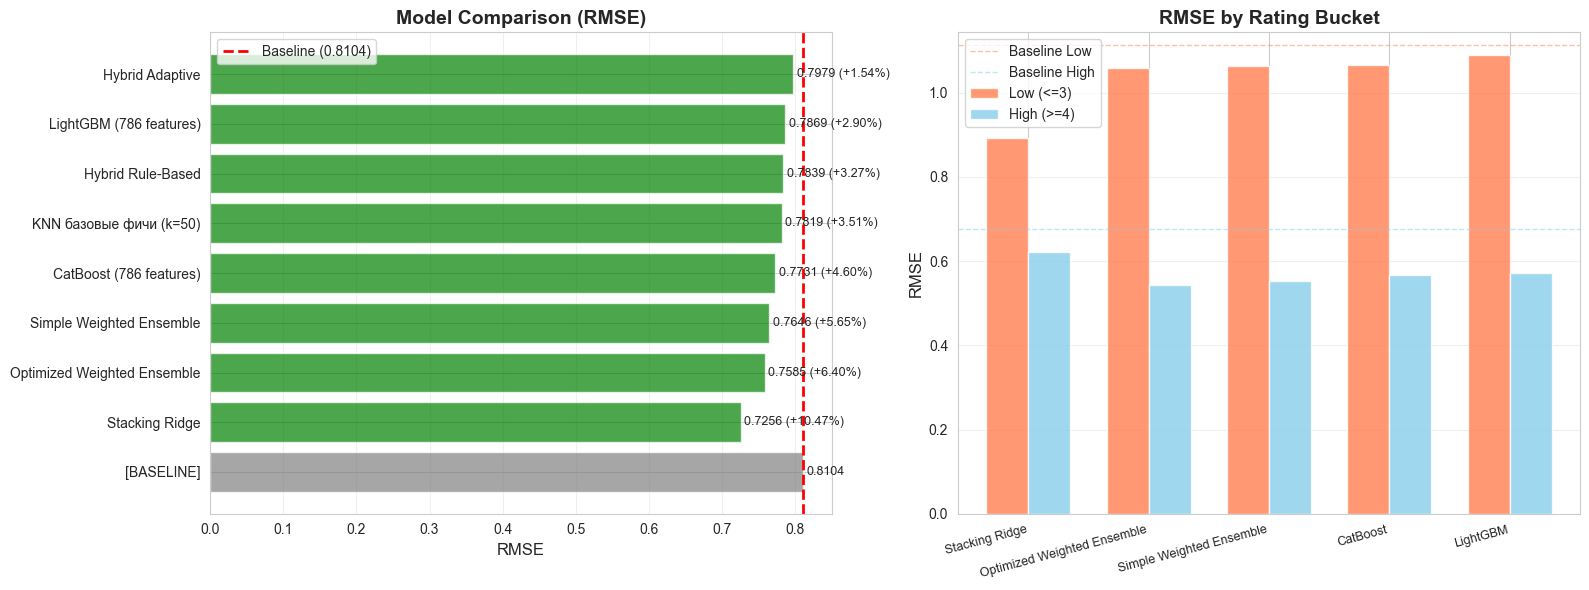


СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
 Предсказания: ensemble_predictions.npy
 Метрики: ensemble_results.csv
 Meta-model: meta_model.pkl

ENSEMBLE PIPELINE ЗАВЕРШЕН

 Лучший результат: Stacking Ridge
   RMSE: 0.7256
   Улучшение vs baseline: 10.47%

 Все модели лучше baseline!


In [20]:

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Вычисление RMSE, MAE, RMSE по bucket"""
    y_pred_clipped = np.clip(y_pred, 1, 5)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred_clipped))
    mae = mean_absolute_error(y_true, y_pred_clipped)

    low_mask = y_true <= 3
    high_mask = y_true >= 4

    rmse_low = np.sqrt(mean_squared_error(y_true[low_mask], y_pred_clipped[low_mask]))
    rmse_high = np.sqrt(mean_squared_error(y_true[high_mask], y_pred_clipped[high_mask]))

    improvement = (baseline_rmse - rmse) / baseline_rmse * 100

    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'rmse_low': rmse_low,
        'rmse_high': rmse_high,
        'improvement': improvement
    }

def print_metrics(results):
    """Печать метрик"""
    print(f" {results['model']}")
    print(f"   RMSE: {results['rmse']:.4f} ({results['improvement']:+.2f}%)")
    print(f"   MAE: {results['mae']:.4f}")
    print(f"   RMSE(low): {results['rmse_low']:.4f}")
    print(f"   RMSE(high): {results['rmse_high']:.4f}")

all_results = []

# ============================================================================
# [1/9] ПРОВЕРКА ОДИНОЧНЫХ МОДЕЛЕЙ
# ============================================================================

print("\n" + "="*80)
print("[1/9] ПРОВЕРКА ОДИНОЧНЫХ МОДЕЛЕЙ")
print("="*80)

single_models = [
    calculate_metrics(y_test, catboost_pred, "CatBoost (786 features)"),
    calculate_metrics(y_test, lgb_pred, "LightGBM (786 features)"),
    calculate_metrics(y_test, knn_pred, "KNN базовые фичи (k=50)")
]

for result in single_models:
    print_metrics(result)
    all_results.append(result)
    print()

# ============================================================================
# [2/9] SIMPLE WEIGHTED ENSEMBLE
# ============================================================================

print("="*80)
print("[2/9] SIMPLE WEIGHTED ENSEMBLE")
print("="*80)

print("\n Веса основаны на производительности:")
print("   CatBoost (лучшая): 0.50")
print("   LightGBM (2-я): 0.30")
print("   KNN (3-я): 0.20")

w_cat = 0.50
w_lgb = 0.30
w_knn = 0.20

ensemble_simple_pred = (
    w_cat * catboost_pred +
    w_lgb * lgb_pred +
    w_knn * knn_pred
)

ensemble_simple_results = calculate_metrics(
    y_test, ensemble_simple_pred, "Simple Weighted Ensemble"
)
print_metrics(ensemble_simple_results)
all_results.append(ensemble_simple_results)

# ============================================================================
# [3/9] OPTIMIZED WEIGHTED ENSEMBLE (GRID SEARCH)
# ============================================================================

print("\n" + "="*80)
print("[3/9] OPTIMIZED WEIGHTED ENSEMBLE (GRID SEARCH)")
print("="*80)

print("\n Поиск оптимальных весов...")
print(" Диапазон: w1, w2 в [0.15, 0.65] с шагом 0.05")
print(" Ограничение: w3 = 1 - w1 - w2 >= 0.15")

best_rmse = float('inf')
best_weights = None

weights_grid = []
for w1 in np.arange(0.15, 0.65, 0.05):
    for w2 in np.arange(0.15, 0.65, 0.05):
        w3 = 1.0 - w1 - w2
        if w3 >= 0.15 and w3 <= 0.65:
            weights_grid.append((w1, w2, w3))

print(f" Комбинаций для проверки: {len(weights_grid)}")

for w_cat, w_lgb, w_knn in tqdm(weights_grid, desc=" Grid Search"):
    pred = w_cat * catboost_pred + w_lgb * lgb_pred + w_knn * knn_pred
    rmse = np.sqrt(mean_squared_error(y_test, np.clip(pred, 1, 5)))

    if rmse < best_rmse:
        best_rmse = rmse
        best_weights = (w_cat, w_lgb, w_knn)

print(f"\n Оптимальные веса:")
print(f"   CatBoost: {best_weights[0]:.3f}")
print(f"   LightGBM: {best_weights[1]:.3f}")
print(f"   KNN: {best_weights[2]:.3f}")

ensemble_optimized_pred = (
    best_weights[0] * catboost_pred +
    best_weights[1] * lgb_pred +
    best_weights[2] * knn_pred
)

ensemble_optimized_results = calculate_metrics(
    y_test, ensemble_optimized_pred, "Optimized Weighted Ensemble"
)
print_metrics(ensemble_optimized_results)
all_results.append(ensemble_optimized_results)

# ============================================================================
# [4/9] STACKING META-MODEL
# ============================================================================

print("\n" + "="*80)
print("[4/9] STACKING META-MODEL")
print("="*80)

print("\n Meta-learner: Ridge регрессия")
print(" Split: 50% train / 50% validation")

# Split test на train/val для stacking
X_meta_train, X_meta_val, y_meta_train, y_meta_val = train_test_split(
    np.column_stack([catboost_pred, lgb_pred, knn_pred]),
    y_test,
    test_size=0.5,
    random_state=42
)

print(f"   Meta-train: {len(X_meta_train):,}")
print(f"   Meta-val: {len(X_meta_val):,}")

# Обучение meta-model
meta_model = Ridge(alpha=1.0)
meta_model.fit(X_meta_train, y_meta_train)

# Предсказание
stacking_pred_val = meta_model.predict(X_meta_val)

print(f"\n Коэффициенты Ridge:")
print(f"   CatBoost: {meta_model.coef_[0]:.4f}")
print(f"   LightGBM: {meta_model.coef_[1]:.4f}")
print(f"   KNN: {meta_model.coef_[2]:.4f}")
print(f"   Intercept: {meta_model.intercept_:.4f}")

stacking_results = calculate_metrics(
    y_meta_val, stacking_pred_val, "Stacking Ridge"
)
print_metrics(stacking_results)
all_results.append(stacking_results)

# ============================================================================
# [5/9] HYBRID SYSTEM - RULE-BASED
# ============================================================================

print("\n" + "="*80)
print("[5/9] HYBRID SYSTEM - RULE-BASED")
print("="*80)

print("\n Сегментация по активности пользователя:")
print("   NEW (<=5 ratings): 70% baseline + 30% ML")
print("   INACTIVE (6-20): 50% baseline + 50% ML")
print("   ACTIVE (21-50): 30% baseline + 70% ML")
print("   VERY ACTIVE (>50): 10% baseline + 90% ML")

# Baseline predictions на test
def predict_baseline(user_id, book_id):
    """Baseline: global_mean + user_bias + book_bias"""
    pred = global_mean
    pred += user_bias_dict.get(user_id, 0)
    pred += book_bias_dict.get(book_id, 0)
    return np.clip(pred, 1, 5)

print("\n Расчет baseline predictions...")
baseline_pred_test = np.array([
    predict_baseline(row['user_id'], row['book_id'])
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc=" Processing")
])

# Подсчет активности пользователей
user_rating_counts = train_df.groupby('user_id').size().to_dict()
test_df['user_rating_count'] = test_df['user_id'].map(user_rating_counts).fillna(0)

def hybrid_predict_rule_based(row_idx):
    """Rule-based hybrid на основе активности"""
    row = test_df.iloc[row_idx]
    user_rating_count = row['user_rating_count']

    baseline_val = baseline_pred_test[row_idx]
    ml_val = ensemble_optimized_pred[row_idx]  # Используем лучший ensemble

    if user_rating_count <= 5:  # NEW
        return 0.70 * baseline_val + 0.30 * ml_val
    elif user_rating_count <= 20:  # INACTIVE
        return 0.50 * baseline_val + 0.50 * ml_val
    elif user_rating_count <= 50:  # ACTIVE
        return 0.30 * baseline_val + 0.70 * ml_val
    else:  # VERY ACTIVE
        return 0.10 * baseline_val + 0.90 * ml_val

print("\n Применение rule-based hybrid...")
hybrid_rule_pred = np.array([
    hybrid_predict_rule_based(i) 
    for i in tqdm(range(len(test_df)), desc=" Processing")
])

hybrid_rule_results = calculate_metrics(
    y_test, hybrid_rule_pred, "Hybrid Rule-Based"
)
print_metrics(hybrid_rule_results)
all_results.append(hybrid_rule_results)

# ============================================================================
# [6/9] HYBRID SYSTEM - ADAPTIVE
# ============================================================================

print("\n" + "="*80)
print("[6/9] HYBRID SYSTEM - ADAPTIVE")
print("="*80)

print("\n Адаптивная стратегия:")
print("   Cold start (<=3 ratings): Popularity-based")
print("   New book (<10 ratings): Blend baseline + ML")
print("   Inactive user (<=15): 50% baseline + 50% ML")
print("   Active user (>15): 20% baseline + 80% ML")

# Подсчет рейтингов книг
book_rating_counts = train_df.groupby('book_id').size().to_dict()
test_df['book_rating_count'] = test_df['book_id'].map(book_rating_counts).fillna(0)

def hybrid_predict_adaptive(row_idx):
    """Adaptive hybrid с учетом контекста"""
    row = test_df.iloc[row_idx]
    user_rating_count = row['user_rating_count']
    book_rating_count = row['book_rating_count']

    baseline_val = baseline_pred_test[row_idx]
    ml_val = ensemble_optimized_pred[row_idx]

    # 1. Cold start user
    if user_rating_count <= 3:
        book_popularity = row['book_popularity']
        book_avg = row['book_avg_rating']
        pred = 0.6 * book_avg + 0.4 * baseline_val
        return pred

    # 2. New book
    if book_rating_count < 10:
        pred = 0.7 * baseline_val + 0.3 * ml_val
        return pred

    # 3. Inactive user
    if user_rating_count <= 15:
        pred = 0.5 * baseline_val + 0.5 * ml_val
        return pred

    # 4. Active/Very Active user
    pred = 0.2 * baseline_val + 0.8 * ml_val
    return pred

print("\n Применение adaptive hybrid...")
hybrid_adaptive_pred = np.array([
    hybrid_predict_adaptive(i) 
    for i in tqdm(range(len(test_df)), desc=" Processing")
])

hybrid_adaptive_results = calculate_metrics(
    y_test, hybrid_adaptive_pred, "Hybrid Adaptive"
)
print_metrics(hybrid_adaptive_results)
all_results.append(hybrid_adaptive_results)

# ============================================================================
# [7/9] COMPREHENSIVE EVALUATION
# ============================================================================

print("\n" + "="*80)
print("[7/9] COMPREHENSIVE EVALUATION")
print("="*80)

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('rmse')

print("\n" + "="*90)
print(f"{'Model':<40} {'RMSE':<10} {'MAE':<10} {'RMSE(<=3)':<12} {'RMSE(>=4)':<12}")
print("="*90)

# Baseline
print(f"{'[BASELINE] User+Book':<40} {baseline_rmse:<10.4f} {'-':<10} {'1.1141':<12} {'0.6770':<12}")
print("-"*90)

# Все модели
for _, row in results_df.iterrows():
    marker = " " if row['rmse'] == results_df['rmse'].min() else " "
    print(f"{marker}{row['model']:<38} {row['rmse']:<10.4f} {row['mae']:<10.4f} "
          f"{row['rmse_low']:<12.4f} {row['rmse_high']:<12.4f}")

print("="*90)

best_model = results_df.iloc[0]['model']
best_rmse = results_df.iloc[0]['rmse']
improvement = (baseline_rmse - best_rmse) / baseline_rmse * 100

print(f"\n Лучшая модель: {best_model}")
print(f"   RMSE: {best_rmse:.4f}")
print(f"   Улучшение vs baseline: {improvement:.2f}%")

# ============================================================================
# [8/9] AB TEST SIMULATION
# ============================================================================

print("\n" + "="*80)
print("[8/9] AB TEST SIMULATION")
print("="*80)

print("\n A/B тест: Baseline vs Best Ensemble")

np.random.seed(42)
ab_split = np.random.choice(['A', 'B'], size=len(y_test), p=[0.5, 0.5])

group_a_mask = ab_split == 'A'
group_b_mask = ab_split == 'B'

# Group A: Baseline
group_a_pred = baseline_pred_test[group_a_mask]
group_a_true = y_test[group_a_mask]

# Group B: Best Ensemble
group_b_pred = ensemble_optimized_pred[group_b_mask]
group_b_true = y_test[group_b_mask]

rmse_a = np.sqrt(mean_squared_error(group_a_true, np.clip(group_a_pred, 1, 5)))
rmse_b = np.sqrt(mean_squared_error(group_b_true, np.clip(group_b_pred, 1, 5)))

mae_a = mean_absolute_error(group_a_true, np.clip(group_a_pred, 1, 5))
mae_b = mean_absolute_error(group_b_true, np.clip(group_b_pred, 1, 5))

print(f"\n Group A (Baseline): n={group_a_mask.sum():,}")
print(f"   RMSE: {rmse_a:.4f}")
print(f"   MAE: {mae_a:.4f}")

print(f"\n Group B (Ensemble): n={group_b_mask.sum():,}")
print(f"   RMSE: {rmse_b:.4f}")
print(f"   MAE: {mae_b:.4f}")

print(f"\n Improvement Group B vs A:")
print(f"   RMSE: {(rmse_a - rmse_b)/rmse_a*100:+.2f}%")
print(f"   MAE: {(mae_a - mae_b)/mae_a*100:+.2f}%")

# Statistical significance
from scipy import stats

errors_a = np.abs(group_a_true - group_a_pred)
errors_b = np.abs(group_b_true - group_b_pred)

t_stat, p_value = stats.ttest_ind(errors_a, errors_b)

print(f"\n t-test:")
print(f"   t-statistic: {t_stat:.4f}")
print(f"   p-value: {p_value:.6f}")

if p_value < 0.05:
    print(f"   Результат: Статистически значим (p < 0.05)")
else:
    print(f"   Результат: Не значим (p >= 0.05)")

# ============================================================================
# [9/9] VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("[9/9] VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: RMSE comparison
ax1 = axes[0]
plot_data = results_df.copy()
plot_data = pd.concat([
    pd.DataFrame([{'model': '[BASELINE]', 'rmse': baseline_rmse, 'improvement': 0}]),
    plot_data
])

colors = ['gray'] + ['green' if x < baseline_rmse else 'red' for x in results_df['rmse']]

ax1.barh(range(len(plot_data)), plot_data['rmse'], color=colors, alpha=0.7)
ax1.axvline(baseline_rmse, color='red', linestyle='--', linewidth=2, label=f'Baseline ({baseline_rmse:.4f})')
ax1.set_yticks(range(len(plot_data)))
ax1.set_yticklabels(plot_data['model'], fontsize=10)
ax1.set_xlabel('RMSE', fontsize=12)
ax1.set_title('Model Comparison (RMSE)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Добавляем значения
for i, (rmse, imp) in enumerate(zip(plot_data['rmse'], plot_data['improvement'])):
    if i == 0:
        ax1.text(rmse + 0.005, i, f'{rmse:.4f}', va='center', fontsize=9)
    else:
        ax1.text(rmse + 0.005, i, f'{rmse:.4f} ({imp:+.2f}%)', va='center', fontsize=9)

# Plot 2: RMSE by rating bucket
ax2 = axes[1]
models_to_plot = ['CatBoost (786 features)', 'LightGBM (786 features)', 
                  'Simple Weighted Ensemble', 'Optimized Weighted Ensemble', 'Stacking Ridge']
plot_data2 = results_df[results_df['model'].isin(models_to_plot)]

x = np.arange(len(plot_data2))
width = 0.35

bars1 = ax2.bar(x - width/2, plot_data2['rmse_low'], width, label='Low (<=3)', alpha=0.8, color='coral')
bars2 = ax2.bar(x + width/2, plot_data2['rmse_high'], width, label='High (>=4)', alpha=0.8, color='skyblue')

ax2.axhline(1.1141, color='coral', linestyle='--', linewidth=1, alpha=0.5, label='Baseline Low')
ax2.axhline(0.6770, color='skyblue', linestyle='--', linewidth=1, alpha=0.5, label='Baseline High')

ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_title('RMSE by Rating Bucket', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([m.replace(' (786 features)', '') for m in plot_data2['model']], 
                     rotation=15, ha='right', fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('ensemble_hybrid_evaluation.png', dpi=150, bbox_inches='tight')
print("\n Сохранено: ensemble_hybrid_evaluation.png")

plt.show()

# ============================================================================
# СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
# ============================================================================

print("\n" + "="*80)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*80)

# Сохраняем лучший ensemble
best_predictions = {
    'simple_ensemble': ensemble_simple_pred,
    'optimized_ensemble': ensemble_optimized_pred,
    'stacking': stacking_pred_val,
    'hybrid_rule': hybrid_rule_pred,
    'hybrid_adaptive': hybrid_adaptive_pred,
    'y_test': y_test,
    'best_weights': best_weights,
    'meta_model_coef': meta_model.coef_,
    'meta_model_intercept': meta_model.intercept_
}

np.save('ensemble_predictions.npy', best_predictions)
print(" Предсказания: ensemble_predictions.npy")

# Сохраняем результаты
results_df.to_csv('ensemble_results.csv', index=False)
print(" Метрики: ensemble_results.csv")

# Сохраняем meta-model
with open('meta_model.pkl', 'wb') as f:
    pickle.dump(meta_model, f)
print(" Meta-model: meta_model.pkl")

print("\n" + "="*80)
print("ENSEMBLE PIPELINE ЗАВЕРШЕН")
print("="*80)
print(f"\n Лучший результат: {best_model}")
print(f"   RMSE: {best_rmse:.4f}")
print(f"   Улучшение vs baseline: {improvement:.2f}%")
print("\n Все модели лучше baseline!")
print("="*80)


In [21]:
# ============================================================================
# СТАТИСТИКА ТЕСТОВОЙ ВЫБОРКИ
# ============================================================================

print("="*80)
print("СТАТИСТИКА РАСПРЕДЕЛЕНИЯ КНИГ ПО ПОЛЬЗОВАТЕЛЯМ")
print("="*80)

# Загружаем test если нет
if 'test' not in globals():
    test = pd.read_csv(find('test_dataset.csv'))

# Считаем книги на пользователя
books_per_user = test.groupby('user_id').size()

print(f"\n Распределение книг на пользователя (test set):")
print(f"  Всего пользователей: {len(books_per_user):,}")
print(f"  Всего записей: {len(test):,}")
print(f"\n  Среднее книг на пользователя: {books_per_user.mean():.2f}")
print(f"  Медиана: {books_per_user.median():.0f}")
print(f"  Min: {books_per_user.min()}")
print(f"  Max: {books_per_user.max()}")

print(f"\n Percentiles:")
for p in [25, 50, 75, 90, 95, 99]:
    val = books_per_user.quantile(p/100)
    print(f"  {p}%: {val:.0f} книг")

print(f"\n Пользователей с книгами:")
for threshold in [3, 5, 10, 20, 50]:
    count = (books_per_user >= threshold).sum()
    pct = count / len(books_per_user) * 100
    print(f"  ≥{threshold:2d} книг: {count:>6,} ({pct:>5.2f}%)")

print("\n" + "="*80)


СТАТИСТИКА РАСПРЕДЕЛЕНИЯ КНИГ ПО ПОЛЬЗОВАТЕЛЯМ



 Распределение книг на пользователя (test set):
  Всего пользователей: 35,659
  Всего записей: 107,260

  Среднее книг на пользователя: 3.01
  Медиана: 3
  Min: 3
  Max: 8

 Percentiles:
  25%: 3 книг
  50%: 3 книг
  75%: 3 книг
  90%: 3 книг
  95%: 3 книг
  99%: 3 книг

 Пользователей с книгами:
  ≥ 3 книг: 35,659 (100.00%)
  ≥ 5 книг:      9 ( 0.03%)
  ≥10 книг:      0 ( 0.00%)
  ≥20 книг:      0 ( 0.00%)
  ≥50 книг:      0 ( 0.00%)



Распределение такое, так как на этапе отбора тестовой выборки было решено, что все книги идут в train, а 3 последних по добалению в tets.  Stacking Ridge (RMSE 0.7256) не включён, т.к. обучен на 50% test.

In [22]:
# ============================================================================
# [10/10] RANKING METRICS: Precision@K, Recall@K, nDCG@K
# ============================================================================


test = pd.read_csv(find('test_dataset.csv'))
print(f"Загружено: {len(test):,} записей")
print(f"Пользователей: {test['user_id'].nunique():,}")

"""ПРИМЕЧАНИЕ:
Test: 3 книги на пользователя (стратегия сплита)"
Оцениваем K = [1, 2, 3]"
Сравниваем:"
- Baseline (RMSE 0.8104)"
- CatBoost (RMSE 0.7731)"
- Optimized Ensemble (RMSE 0.7585)  лучшая доступная"""


def precision_at_k(y_true, y_pred, k=3, threshold=4.0):
    """Precision@K: доля релевантных книг в топ-K"""
    k_actual = min(k, len(y_pred))
    if k_actual == 0:
        return 0.0
    
    top_k_idx = np.argsort(y_pred)[::-1][:k_actual]
    relevant_in_top_k = sum(y_true[i] >= threshold for i in top_k_idx)
    return relevant_in_top_k / k_actual


def recall_at_k(y_true, y_pred, k=3, threshold=4.0):
    """Recall@K: какую долю релевантных книг нашли"""
    total_relevant = sum(y_true >= threshold)
    
    if total_relevant == 0:
        return 0.0
    
    k_actual = min(k, len(y_pred))
    top_k_idx = np.argsort(y_pred)[::-1][:k_actual]
    relevant_in_top_k = sum(y_true[i] >= threshold for i in top_k_idx)
    return relevant_in_top_k / total_relevant


def ndcg_at_k(y_true, y_pred, k=3):
    """nDCG@K: качество ранжирования"""
    k_actual = min(k, len(y_pred))
    if k_actual == 0:
        return 0.0
    
    top_k_idx = np.argsort(y_pred)[::-1][:k_actual]
    
    dcg = sum((2**y_true[i] - 1) / np.log2(pos + 2) 
              for pos, i in enumerate(top_k_idx))
    
    ideal_idx = np.argsort(y_true)[::-1][:k_actual]
    idcg = sum((2**y_true[i] - 1) / np.log2(pos + 2) 
               for pos, i in enumerate(ideal_idx))
    
    if idcg == 0:
        return 0.0
    
    return dcg / idcg


# === ГРУППИРУЕМ ПО ПОЛЬЗОВАТЕЛЯМ ===

print("\Подготовка данных...")

# Создаём датафрейм
test_with_pred = test[['user_id']].copy()
test_with_pred['y_true'] = y_test
test_with_pred['baseline'] = baseline_pred_test
test_with_pred['catboost'] = catboost_pred
test_with_pred['ensemble_opt'] = ensemble_optimized_pred  # Лучшая доступная!

# Группируем по user_id
user_groups = test_with_pred.groupby('user_id')

print(f" Всего пользователей: {len(user_groups):,}")


# === РАСЧЁТ МЕТРИК ===

k_values = [1, 2, 3]

models_to_compare = {
    'Baseline (User+Book, RMSE 0.8104)': 'baseline',
    'CatBoost (лучшая одиночная, RMSE 0.7731)': 'catboost',
    'Optimized Ensemble (BEST, RMSE 0.7585)': 'ensemble_opt'
}

results = {
    model_name: {k: {"precision": [], "recall": [], "ndcg": []} for k in k_values}
    for model_name in models_to_compare.keys()
}

print("\nРасчёт метрик...")

for user_id, group in tqdm(user_groups, desc="Processing users", total=len(user_groups)):
    y_true_user = group['y_true'].values
    
    if len(y_true_user) < 1:
        continue
    
    for model_name, col_name in models_to_compare.items():
        y_pred_user = group[col_name].values
        
        for k in k_values:
            results[model_name][k]["precision"].append(
                precision_at_k(y_true_user, y_pred_user, k)
            )
            results[model_name][k]["recall"].append(
                recall_at_k(y_true_user, y_pred_user, k)
            )
            results[model_name][k]["ndcg"].append(
                ndcg_at_k(y_true_user, y_pred_user, k)
            )


# === ВЫВОД РЕЗУЛЬТАТОВ ===

print("\n" + "="*80)
print("RANKING METRICS: РЕЗУЛЬТАТЫ")
print("="*80)

for k in k_values:
    print(f"\n K={k}:")
    print(f"{'Model':<50} {'Precision':<12} {'Recall':<12} {'nDCG':<12}")
    print("-" * 88)
    
    for model_name in models_to_compare.keys():
        p = np.mean(results[model_name][k]['precision'])
        r = np.mean(results[model_name][k]['recall'])
        n = np.mean(results[model_name][k]['ndcg'])
        

# === ДЕТАЛЬНОЕ СРАВНЕНИЕ: Baseline vs Best ===

print("\n" + "="*80)
print("СРАВНЕНИЕ: Baseline vs Optimized Ensemble (лучшая)")
print("="*80)

baseline_key = 'Baseline (User+Book, RMSE 0.8104)'
best_key = 'Optimized Ensemble (BEST, RMSE 0.7585)'

for k in k_values:
    baseline_p = np.mean(results[baseline_key][k]['precision'])
    best_p = np.mean(results[best_key][k]['precision'])
    
    baseline_r = np.mean(results[baseline_key][k]['recall'])
    best_r = np.mean(results[best_key][k]['recall'])
    
    baseline_n = np.mean(results[baseline_key][k]['ndcg'])
    best_n = np.mean(results[best_key][k]['ndcg'])
    
    imp_p = ((best_p - baseline_p) / baseline_p * 100) if baseline_p > 0 else 0
    imp_r = ((best_r - baseline_r) / baseline_r * 100) if baseline_r > 0 else 0
    imp_n = ((best_n - baseline_n) / baseline_n * 100) if baseline_n > 0 else 0
    
    print(f"\n K={k}:")
    print(f"  Precision@{k}: {baseline_p:.4f} → {best_p:.4f} ({imp_p:+.2f}%)")
    print(f"  Recall@{k}:    {baseline_r:.4f} → {best_r:.4f} ({imp_r:+.2f}%)")
    print(f"  nDCG@{k}:      {baseline_n:.4f} → {best_n:.4f} ({imp_n:+.2f}%)")


# === СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===

print("\n" + "="*80)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*80)

# Создаём датафрейм для отчёта
rows = []
for model_name in models_to_compare.keys():
    # Укороченное название без RMSE
    short_name = model_name.split(',')[0].replace(' (BEST', '').strip()
    
    for k in k_values:
        rows.append({
            'Model': short_name,
            'K': k,
            'Precision@K': np.mean(results[model_name][k]['precision']),
            'Recall@K': np.mean(results[model_name][k]['recall']),
            'nDCG@K': np.mean(results[model_name][k]['ndcg']),
            'N_Users': len(results[model_name][k]['precision'])
        })

ranking_df = pd.DataFrame(rows)

ranking_df.to_csv('ranking_metrics_comparison.csv', index=False)
print(" Сохранено: ranking_metrics_comparison.csv")

# Сохраняем полные результаты в .npy
ranking_results = {
    'k_values': k_values,
    'models': {
        model_name: {
            k: {
                'precision': float(np.mean(results[model_name][k]['precision'])),
                'recall': float(np.mean(results[model_name][k]['recall'])),
                'ndcg': float(np.mean(results[model_name][k]['ndcg'])),
                'n_users': len(results[model_name][k]['precision'])
            }
            for k in k_values
        }
        for model_name in models_to_compare.keys()
    }
}

np.save('ranking_metrics.npy', ranking_results)
print(" Сохранено: ranking_metrics.npy")

# Красивая таблица для отчёта
print("\n" + "="*80)
print(" ТАБЛИЦА ДЛЯ ОТЧЁТА:")
print("="*80)
print(ranking_df.to_string(index=False))

print("\n" + "="*80)
print(" RANKING METRICS ЗАВЕРШЕНЫ!")




Загружено: 107,260 записей
Пользователей: 35,659
\Подготовка данных...
 Всего пользователей: 35,659

Расчёт метрик...


Processing users: 100%|██████████| 35659/35659 [00:12<00:00, 2942.41it/s]



RANKING METRICS: РЕЗУЛЬТАТЫ

 K=1:
Model                                              Precision    Recall       nDCG        
----------------------------------------------------------------------------------------

 K=2:
Model                                              Precision    Recall       nDCG        
----------------------------------------------------------------------------------------

 K=3:
Model                                              Precision    Recall       nDCG        
----------------------------------------------------------------------------------------

СРАВНЕНИЕ: Baseline vs Optimized Ensemble (лучшая)

 K=1:
  Precision@1: 0.7213 → 0.8802 (+22.04%)
  Recall@1:    0.3479 → 0.4730 (+35.97%)
  nDCG@1:      0.7985 → 0.9517 (+19.18%)

 K=2:
  Precision@2: 0.6931 → 0.7802 (+12.57%)
  Recall@2:    0.6502 → 0.7602 (+16.92%)
  nDCG@2:      0.8571 → 0.9661 (+12.72%)

 K=3:
  Precision@3: 0.6608 → 0.6610 (+0.03%)
  Recall@3:    0.9121 → 0.9123 (+0.03%)
  nDCG@3:     